In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

# Path to your CSV file on Google Drive
file_path = '/content/drive/MyDrive/data_folder/Collected_File.csv'

# Read the CSV file
df_Read = pd.read_csv(file_path)

In [ ]:
import pandas as pd

# Assuming df_Read is already loaded

# Convert datetime column to datetime type if not already
df_Read['datetime'] = pd.to_datetime(df_Read['datetime'])

# Group by CellID and datetime, summing the internet traffic
df_grouped = df_Read.groupby(['CellID', 'datetime'], as_index=False)['internet'].sum()

# Set datetime as index
df_grouped = df_grouped.set_index('datetime')

print(df_grouped.head())
print(f"New shape: {df_grouped.shape}")

                     CellID    internet
datetime                               
2013-11-01 00:00:00    4546  503.736286
2013-11-01 00:10:00    4546  551.313816
2013-11-01 00:20:00    4546  527.631979
2013-11-01 00:30:00    4546  569.648635
2013-11-01 00:40:00    4546  674.550847
New shape: (820200, 2)


In [ ]:
# Filter only CellID 4755
cell_4755 = df_grouped[df_grouped['CellID'] == 4755].copy()

# Drop CellID column since it's constant now
cell_4755.drop(columns='CellID', inplace=True)

# Sort by datetime just in case
cell_4755 = cell_4755.sort_index()

print(cell_4755.head())
print(cell_4755.shape)

                        internet
datetime                        
2013-11-01 00:00:00  1882.835224
2013-11-01 00:10:00  1792.001814
2013-11-01 00:20:00  1721.562928
2013-11-01 00:30:00  1608.051995
2013-11-01 00:40:00  1533.467322
(8202, 1)


In [ ]:
# Extract data between 2013-11-05 and 2013-12-05 (inclusive)
start_date = '2013-11-05'
end_date = '2013-12-05'

cell_4755_subset = cell_4755.loc[start_date:end_date].copy()

print(cell_4755_subset.head())
print(cell_4755_subset.shape)

                       internet
datetime                       
2013-11-05 00:00:00  637.314733
2013-11-05 00:10:00  617.837502
2013-11-05 00:20:00  594.127909
2013-11-05 00:30:00  621.263989
2013-11-05 00:40:00  610.602649
(4464, 1)


In [ ]:
is_regular = (cell_4755_subset.index.to_series().diff().dropna() == pd.Timedelta('10min')).all()
print("Regular 10min interval:", is_regular)


Regular 10min interval: True


In [ ]:
import pandas as pd

cell_4755_subset_Model = cell_4755_subset.copy()

print(cell_4755_subset_Model.head())
print(f"Data shape: {cell_4755_subset_Model.shape}")


                       internet
datetime                       
2013-11-05 00:00:00  637.314733
2013-11-05 00:10:00  617.837502
2013-11-05 00:20:00  594.127909
2013-11-05 00:30:00  621.263989
2013-11-05 00:40:00  610.602649
Data shape: (4464, 1)


In [ ]:
is_regular = (cell_4755_subset_Model.index.to_series().diff().dropna() == pd.Timedelta('10min')).all()
print("Regular 10min interval:", is_regular)


Regular 10min interval: True


In [ ]:
# Create the expected full 10-minute time index
full_index = pd.date_range(
    start=cell_4755_subset_Model.index.min(),
    end=cell_4755_subset_Model.index.max(),
    freq='10min'
)

# Find missing timestamps
missing = full_index.difference(cell_4755_subset_Model.index)
print(f"Number of missing timestamps: {len(missing)}")
print("First 10 missing timestamps:")
print(missing[:10])


Number of missing timestamps: 0
First 10 missing timestamps:
DatetimeIndex([], dtype='datetime64[ns]', freq='10min')


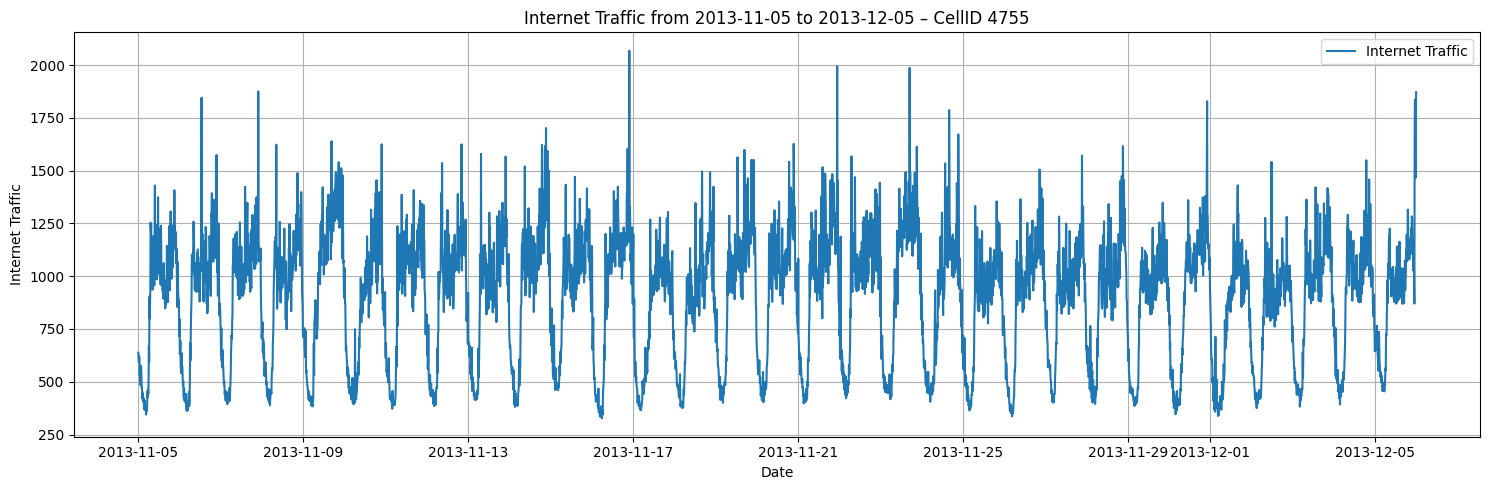

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(cell_4755_subset_Model.index, cell_4755_subset_Model['internet'], label='Internet Traffic')
plt.title('Internet Traffic from 2013-11-05 to 2013-12-05 – CellID 4755')
plt.xlabel('Date')
plt.ylabel('Internet Traffic')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


outliers

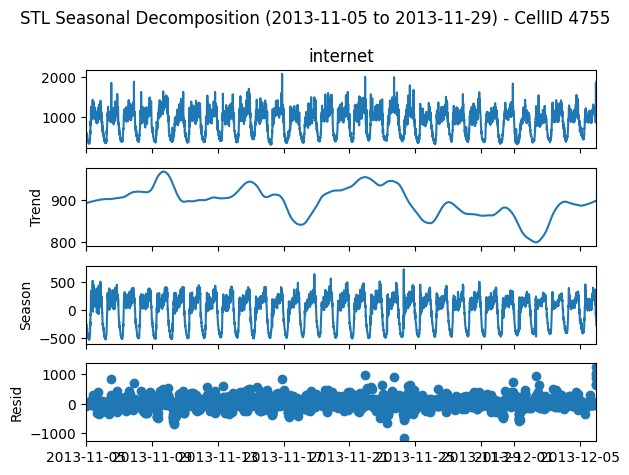

In [ ]:
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt

stl = STL(cell_4755_subset_Model['internet'], period=144, robust=True)  # 144 = daily cycle
res = stl.fit()

res.plot()
plt.suptitle('STL Seasonal Decomposition (2013-11-05 to 2013-11-29) - CellID 4755')
plt.tight_layout()
plt.show()


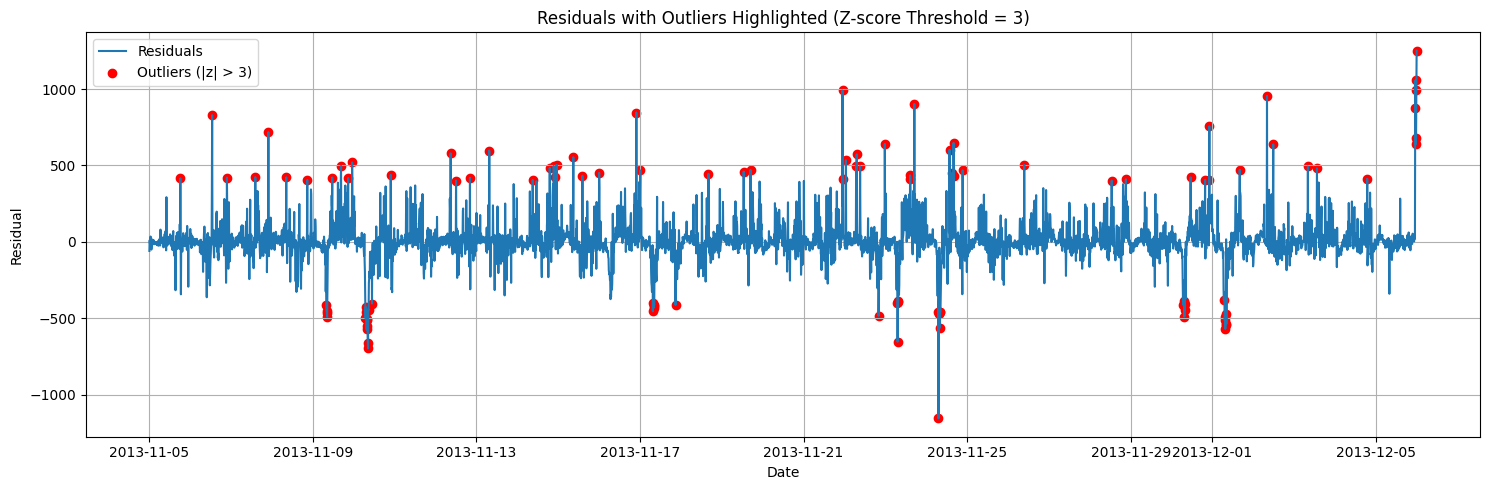

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore

# Extract residuals from STL result
residuals = res.resid

# Calculate z-score of residuals
z_scores = zscore(residuals)

# Define an outlier threshold (commonly 3 or -3)
threshold = 3

# Identify outliers
outliers = np.where(np.abs(z_scores) > threshold)[0]

# Plot residuals and mark outliers
plt.figure(figsize=(15, 5))
plt.plot(residuals.index, residuals, label='Residuals')
plt.scatter(residuals.index[outliers], residuals.iloc[outliers], color='red', label='Outliers (|z| > 3)')
plt.title('Residuals with Outliers Highlighted (Z-score Threshold = 3)')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Create a DataFrame with residuals and z-scores
residuals_df = pd.DataFrame({
    'Residual': residuals,
    'Z_score': z_scores
})

# Filter the outliers (|z| > 3)
outliers_df = residuals_df[np.abs(residuals_df['Z_score']) > 3]

# Display number of outliers
print(f"Number of outliers detected: {len(outliers_df)}")

# Show detailed info: date, residual, z-score
print(outliers_df)


Number of outliers detected: 110
                        Residual   Z_score
datetime                                  
2013-11-05 18:10:00   415.165198  3.117215
2013-11-06 12:50:00   828.808623  6.306942
2013-11-06 21:30:00   420.802654  3.160687
2013-11-07 14:10:00   423.878022  3.184402
2013-11-07 21:50:00   718.281116  5.454632
...                          ...       ...
2013-12-05 23:10:00  1058.476187  8.077977
2013-12-05 23:20:00   639.930340  4.850446
2013-12-05 23:30:00   681.493664  5.170953
2013-12-05 23:40:00   995.110420  7.589345
2013-12-05 23:50:00  1251.184072  9.564004

[110 rows x 2 columns]


In [ ]:
# Get timestamps of outliers
outlier_timestamps = outliers_df.index

# Remove these timestamps from the original data
cell_4755_subset_Model = cell_4755_subset_Model.drop(index=outlier_timestamps)

print(f"Original data shape: {cell_4755_subset_Model.shape}")
print(f"Cleaned data shape: {cell_4755_subset_Model.shape}")


Original data shape: (4354, 1)
Cleaned data shape: (4354, 1)


In [ ]:
is_regular = (cell_4755_subset_Model.index.to_series().diff().dropna() == pd.Timedelta('10min')).all()
print("Regular 10min interval:", is_regular)


Regular 10min interval: False


In [ ]:
# Create the expected full 10-minute time index
full_index = pd.date_range(
    start=cell_4755_subset_Model.index.min(),
    end=cell_4755_subset_Model.index.max(),
    freq='10min'
)

# Find missing timestamps
missing = full_index.difference(cell_4755_subset_Model.index)
print(f"Number of missing timestamps: {len(missing)}")
print("First 10 missing timestamps:")
print(missing[:10])


Number of missing timestamps: 104
First 10 missing timestamps:
DatetimeIndex(['2013-11-05 18:10:00', '2013-11-06 12:50:00',
               '2013-11-06 21:30:00', '2013-11-07 14:10:00',
               '2013-11-07 21:50:00', '2013-11-08 08:20:00',
               '2013-11-08 20:40:00', '2013-11-09 07:50:00',
               '2013-11-09 08:00:00', '2013-11-09 08:10:00'],
              dtype='datetime64[ns]', freq=None)


In [ ]:
'''import numpy as np
import pandas as pd

# Step 1: Store original cleaned data
cleaned_data = cell_4755_subset_Model.copy()

# Step 2: Create a full datetime index (every 10 minutes)
full_index = pd.date_range(
    start=cleaned_data.index.min(),
    end=cleaned_data.index.max(),
    freq='10T'  # 10-minute intervals
)

# Step 3: Reindex to add back missing timestamps (these will have NaNs)
reindexed_data = cleaned_data.reindex(full_index)

# Step 4: Apply seasonal interpolation
# We use a 1-day seasonal period → 144 steps (24 hours * 6 per hour)
seasonal_period = 144

# Interpolate with seasonal lags
for i in range(len(reindexed_data)):
    if pd.isna(reindexed_data.iloc[i]['internet']):
        # Try using same time on previous day
        if i - seasonal_period >= 0:
            reindexed_data.iloc[i, reindexed_data.columns.get_loc('internet')] = reindexed_data.iloc[i - seasonal_period]['internet']

# Optional: If some values still NaN (e.g., first day), use linear interpolation
#reindexed_data['internet'] = reindexed_data['internet'].interpolate(method='linear')

# Step 5: Rename back
cell_4755_subset_Model = reindexed_data
'''

"import numpy as np\nimport pandas as pd\n\n# Step 1: Store original cleaned data\ncleaned_data = cell_4755_subset_Model.copy()\n\n# Step 2: Create a full datetime index (every 10 minutes)\nfull_index = pd.date_range(\n    start=cleaned_data.index.min(),\n    end=cleaned_data.index.max(),\n    freq='10T'  # 10-minute intervals\n)\n\n# Step 3: Reindex to add back missing timestamps (these will have NaNs)\nreindexed_data = cleaned_data.reindex(full_index)\n\n# Step 4: Apply seasonal interpolation\n# We use a 1-day seasonal period → 144 steps (24 hours * 6 per hour)\nseasonal_period = 144\n\n# Interpolate with seasonal lags\nfor i in range(len(reindexed_data)):\n    if pd.isna(reindexed_data.iloc[i]['internet']):\n        # Try using same time on previous day\n        if i - seasonal_period >= 0:\n            reindexed_data.iloc[i, reindexed_data.columns.get_loc('internet')] = reindexed_data.iloc[i - seasonal_period]['internet']\n\n# Optional: If some values still NaN (e.g., first day), u

In [ ]:
import pandas as pd

# STEP 1: Save the original timestamps of outliers
outlier_timestamps = outliers_df.index

# STEP 2: Drop them from the dataset
#cell_4755_subset_Model = cell_4755_subset_Model.drop(index=outlier_timestamps)

# STEP 3: Create a copy to restore dropped timestamps (with NaN)
# This will preserve the original shape and order
cell_4755_filled = cell_4755_subset_Model.copy()

# Reinsert dropped timestamps with NaN internet values
for timestamp in outlier_timestamps:
    if timestamp not in cell_4755_filled.index:
        cell_4755_filled.loc[timestamp] = [np.nan]

# Sort the index to maintain chronological order
cell_4755_filled = cell_4755_filled.sort_index()

# STEP 4: Apply seasonal interpolation (1-day lag = 144 for 10-min intervals)
seasonal_period = 144

# Fill missing internet values using previous day's same time
internet_values = cell_4755_filled['internet'].copy()

for i in range(len(internet_values)):
    if pd.isna(internet_values.iloc[i]) and i - seasonal_period >= 0:
        internet_values.iloc[i] = internet_values.iloc[i - seasonal_period]

# Optional: fallback to linear interpolation if some NaNs remain
internet_values = internet_values.interpolate(method='linear')

# Update the dataset
cell_4755_filled['internet'] = internet_values

# Step 5: Rename back
cell_4755_subset_Model = cell_4755_filled

# ✅ Result: same shape, same timestamps — only outliers filled using seasonal interpolation


In [ ]:
is_regular = (cell_4755_subset_Model.index.to_series().diff().dropna() == pd.Timedelta('10min')).all()
print("Regular 10min interval:", is_regular)


Regular 10min interval: True


In [ ]:
# Create the expected full 10-minute time index
full_index = pd.date_range(
    start=cell_4755_subset_Model.index.min(),
    end=cell_4755_subset_Model.index.max(),
    freq='10min'
)

# Find missing timestamps
missing = full_index.difference(cell_4755_subset_Model.index)
print(f"Number of missing timestamps: {len(missing)}")
print("First 10 missing timestamps:")
print(missing[:10])


Number of missing timestamps: 0
First 10 missing timestamps:
DatetimeIndex([], dtype='datetime64[ns]', freq='10min')


seasonality

In [ ]:
import numpy as np

def create_fourier_terms(index, period, order, prefix):
    t = np.arange(len(index))
    terms = {}
    for k in range(1, order + 1):
        terms[f'{prefix}_sin_{k}'] = np.sin(2 * np.pi * k * t / period)
        terms[f'{prefix}_cos_{k}'] = np.cos(2 * np.pi * k * t / period)
    return pd.DataFrame(terms, index=index)

# Harmonics parameters
seasonal_period = 144  # daily seasonality in 10-min intervals
seasonal_order = 3

trend_period = len(cell_4755_subset_Model)  # whole length to capture slow trend cycles
trend_order = 2

# Generate regressors
seasonal_terms = create_fourier_terms(cell_4755_subset_Model.index, seasonal_period, seasonal_order, 'seasonal')
trend_terms = create_fourier_terms(cell_4755_subset_Model.index, trend_period, trend_order, 'trend')

harmonic_regressors = pd.concat([seasonal_terms, trend_terms], axis=1)
print(harmonic_regressors.head())


                     seasonal_sin_1  seasonal_cos_1  seasonal_sin_2  \
datetime                                                              
2013-11-05 00:00:00        0.000000        1.000000        0.000000   
2013-11-05 00:10:00        0.043619        0.999048        0.087156   
2013-11-05 00:20:00        0.087156        0.996195        0.173648   
2013-11-05 00:30:00        0.130526        0.991445        0.258819   
2013-11-05 00:40:00        0.173648        0.984808        0.342020   

                     seasonal_cos_2  seasonal_sin_3  seasonal_cos_3  \
datetime                                                              
2013-11-05 00:00:00        1.000000        0.000000        1.000000   
2013-11-05 00:10:00        0.996195        0.130526        0.991445   
2013-11-05 00:20:00        0.984808        0.258819        0.965926   
2013-11-05 00:30:00        0.965926        0.382683        0.923880   
2013-11-05 00:40:00        0.939693        0.500000        0.866025   

    

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp86d66a18/8cyubaxa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp86d66a18/xep14x5x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82556', 'data', 'file=/tmp/tmp86d66a18/8cyubaxa.json', 'init=/tmp/tmp86d66a18/xep14x5x.json', 'output', 'file=/tmp/tmp86d66a18/prophet_modelfhy75kxh/prophet_model-20250525145353.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:53:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:53:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


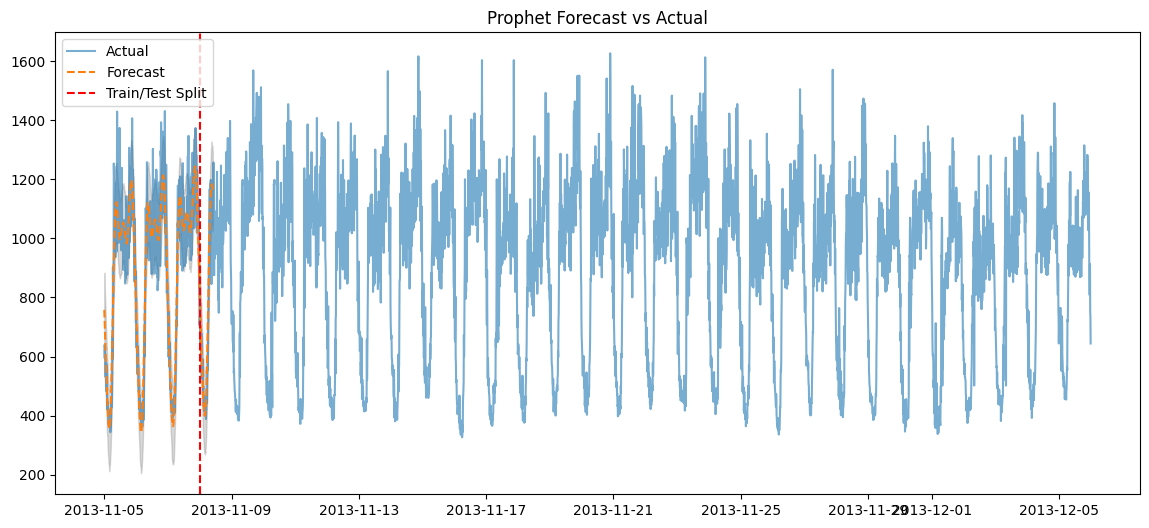

In [ ]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Step 1: Prepare the DataFrame
df = cell_4755_subset_Model.copy()
df_prophet = df.reset_index().rename(columns={'datetime': 'ds', 'internet': 'y'})

# Step 2: Create Fourier terms (same as before)
# harmonic_regressors is assumed already created using create_fourier_terms()
harmonic_regressors_prophet = harmonic_regressors.reset_index(drop=True)

# Step 3: Split data BEFORE computing historical mean
train_size = 432
test_size = 60

train_df = df_prophet.iloc[:train_size].copy()
test_df = df_prophet.iloc[train_size:train_size + test_size].copy()

# Step 4: Compute rolling mean only on training
rolling_window = 144  # 1 day
train_historical_mean = train_df['y'].rolling(window=rolling_window, min_periods=1).mean()
train_historical_mean.name = 'historical_mean'

# Step 5: For test, fill with last value of training mean
last_mean = train_historical_mean.iloc[-1]
test_historical_mean = pd.Series([last_mean] * test_size, index=test_df.index, name='historical_mean')

# Step 6: Combine safely
historical_mean = pd.concat([train_historical_mean, test_historical_mean]).reset_index(drop=True)

# Step 7: Add regressors
df_prophet = pd.concat([
    df_prophet,
    harmonic_regressors_prophet,
    historical_mean
], axis=1)

# Step 8: Prophet modeling
model = Prophet()

for col in harmonic_regressors.columns:
    model.add_regressor(col)
model.add_regressor('historical_mean')

# Train the model
model.fit(df_prophet.iloc[:train_size])

# Prepare future dataframe
future = df_prophet.iloc[:train_size + test_size].copy()

# Forecast
forecast = model.predict(future)

# Plot
plt.figure(figsize=(14, 6))
plt.plot(df_prophet['ds'], df_prophet['y'], label='Actual', alpha=0.6)
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', linestyle='--')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='gray', alpha=0.3)
plt.axvline(df_prophet['ds'].iloc[train_size], color='red', linestyle='--', label='Train/Test Split')
plt.legend()
plt.title("Prophet Forecast vs Actual")
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Get actual and predicted values on test set
y_true = df_prophet['y'].iloc[train_size:train_size + test_size].values
y_pred = forecast['yhat'].iloc[train_size:train_size + test_size].values

# Compute metrics
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAPE: {mape:.2f}%")


MAE: 74.474
RMSE: 97.013
MAPE: 10.70%


In [ ]:
accuracy = 100 - mape
print(f"Custom Accuracy: {accuracy:.2f}%")


Custom Accuracy: 89.30%


In [ ]:
'''rolling_window = seasonal_period  # 1 day

historical_mean = cell_4755_subset_Model['internet'].rolling(window=rolling_window, min_periods=1).mean()
historical_mean.name = 'historical_mean'

# Combine all regressors
#exog = pd.concat([harmonic_regressors, historical_mean], axis=1)
#print(exog.head())
'''

"rolling_window = seasonal_period  # 1 day\n\nhistorical_mean = cell_4755_subset_Model['internet'].rolling(window=rolling_window, min_periods=1).mean()\nhistorical_mean.name = 'historical_mean'\n\n# Combine all regressors\n#exog = pd.concat([harmonic_regressors, historical_mean], axis=1)\n#print(exog.head())\n"

Short Term

In [ ]:
'''import pandas as pd
from prophet import Prophet

# Step 1: Prepare the DataFrame
df = cell_4755_subset_Model.copy()
df_prophet = df.reset_index().rename(columns={'datetime': 'ds', 'internet': 'y'})

# Step 2: Add harmonic regressors
# Reuse the harmonic_regressors and historical_mean you already created
harmonic_regressors_prophet = harmonic_regressors.reset_index(drop=True)
historical_mean_prophet = historical_mean.reset_index(drop=True)

# Combine all
df_prophet = pd.concat([df_prophet, harmonic_regressors_prophet, historical_mean_prophet], axis=1)

# Step 3: Split data
train_size = 432
test_size = 60

train_df = df_prophet.iloc[:train_size]
test_df = df_prophet.iloc[train_size:train_size + test_size]

# Step 4: Initialize and add regressors
model = Prophet()

# Add Fourier + historical mean regressors
for col in harmonic_regressors.columns:
    model.add_regressor(col)

model.add_regressor('historical_mean')

# Step 5: Fit the model
model.fit(train_df)

# Step 6: Create future dataframe
future = df_prophet[['ds']].iloc[:train_size + test_size].copy()

# Add regressors to future
future = pd.concat([
    future.reset_index(drop=True),
    harmonic_regressors.iloc[:train_size + test_size].reset_index(drop=True),
    historical_mean.iloc[:train_size + test_size].reset_index(drop=True)
], axis=1)

# Step 7: Forecast
forecast = model.predict(future)

# Step 8: Visualize
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(df_prophet['ds'], df_prophet['y'], label='Actual', alpha=0.6)
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', linestyle='--')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='gray', alpha=0.3)
plt.axvline(df_prophet['ds'].iloc[train_size], color='red', linestyle='--', label='Train/Test Split')
plt.legend()
plt.title("Prophet Forecast vs Actual")
plt.show()
'''

'import pandas as pd\nfrom prophet import Prophet\n\n# Step 1: Prepare the DataFrame\ndf = cell_4755_subset_Model.copy()\ndf_prophet = df.reset_index().rename(columns={\'datetime\': \'ds\', \'internet\': \'y\'})\n\n# Step 2: Add harmonic regressors\n# Reuse the harmonic_regressors and historical_mean you already created\nharmonic_regressors_prophet = harmonic_regressors.reset_index(drop=True)\nhistorical_mean_prophet = historical_mean.reset_index(drop=True)\n\n# Combine all\ndf_prophet = pd.concat([df_prophet, harmonic_regressors_prophet, historical_mean_prophet], axis=1)\n\n# Step 3: Split data\ntrain_size = 432\ntest_size = 60\n\ntrain_df = df_prophet.iloc[:train_size]\ntest_df = df_prophet.iloc[train_size:train_size + test_size]\n\n# Step 4: Initialize and add regressors\nmodel = Prophet()\n\n# Add Fourier + historical mean regressors\nfor col in harmonic_regressors.columns:\n    model.add_regressor(col)\n\nmodel.add_regressor(\'historical_mean\')\n\n# Step 5: Fit the model\nmodel.f

In [ ]:
'''from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Get actual and predicted values on test set
y_true = df_prophet['y'].iloc[train_size:train_size + test_size].values
y_pred = forecast['yhat'].iloc[train_size:train_size + test_size].values

# Compute metrics
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAPE: {mape:.2f}%")
'''

'from sklearn.metrics import mean_absolute_error, mean_squared_error\nimport numpy as np\n\n# Get actual and predicted values on test set\ny_true = df_prophet[\'y\'].iloc[train_size:train_size + test_size].values\ny_pred = forecast[\'yhat\'].iloc[train_size:train_size + test_size].values\n\n# Compute metrics\nmae = mean_absolute_error(y_true, y_pred)\nrmse = np.sqrt(mean_squared_error(y_true, y_pred))\nmape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100\n\nprint(f"MAE: {mae:.3f}")\nprint(f"RMSE: {rmse:.3f}")\nprint(f"MAPE: {mape:.2f}%")\n'

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp86d66a18/s9l18zpw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp86d66a18/xjb5_7uj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37711', 'data', 'file=/tmp/tmp86d66a18/s9l18zpw.json', 'init=/tmp/tmp86d66a18/xjb5_7uj.json', 'output', 'file=/tmp/tmp86d66a18/prophet_model27_0z4xn/prophet_model-20250525145354.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:53:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:53:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


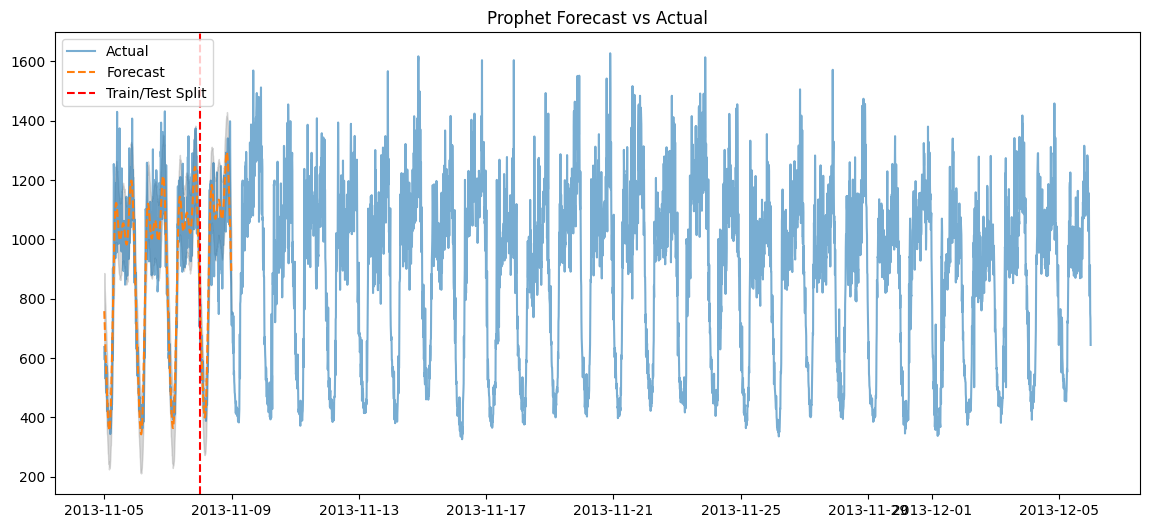

In [ ]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Step 1: Prepare the DataFrame
df = cell_4755_subset_Model.copy()
df_prophet = df.reset_index().rename(columns={'datetime': 'ds', 'internet': 'y'})

# Step 2: Create Fourier terms (same as before)
# harmonic_regressors is assumed already created using create_fourier_terms()
harmonic_regressors_prophet = harmonic_regressors.reset_index(drop=True)

# Step 3: Split data BEFORE computing historical mean
train_size = 432
test_size = 144

train_df = df_prophet.iloc[:train_size].copy()
test_df = df_prophet.iloc[train_size:train_size + test_size].copy()

# Step 4: Compute rolling mean only on training
rolling_window = 144  # 1 day
train_historical_mean = train_df['y'].rolling(window=rolling_window, min_periods=1).mean()
train_historical_mean.name = 'historical_mean'

# Step 5: For test, fill with last value of training mean
last_mean = train_historical_mean.iloc[-1]
test_historical_mean = pd.Series([last_mean] * test_size, index=test_df.index, name='historical_mean')

# Step 6: Combine safely
historical_mean = pd.concat([train_historical_mean, test_historical_mean]).reset_index(drop=True)

# Step 7: Add regressors
df_prophet = pd.concat([
    df_prophet,
    harmonic_regressors_prophet,
    historical_mean
], axis=1)

# Step 8: Prophet modeling
model = Prophet()

for col in harmonic_regressors.columns:
    model.add_regressor(col)
model.add_regressor('historical_mean')

# Train the model
model.fit(df_prophet.iloc[:train_size])

# Prepare future dataframe
future = df_prophet.iloc[:train_size + test_size].copy()

# Forecast
forecast = model.predict(future)

# Plot
plt.figure(figsize=(14, 6))
plt.plot(df_prophet['ds'], df_prophet['y'], label='Actual', alpha=0.6)
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', linestyle='--')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='gray', alpha=0.3)
plt.axvline(df_prophet['ds'].iloc[train_size], color='red', linestyle='--', label='Train/Test Split')
plt.legend()
plt.title("Prophet Forecast vs Actual")
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Get actual and predicted values on test set
y_true = df_prophet['y'].iloc[train_size:train_size + test_size].values
y_pred = forecast['yhat'].iloc[train_size:train_size + test_size].values

# Compute metrics
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAPE: {mape:.2f}%")


MAE: 96.944
RMSE: 123.794
MAPE: 11.07%


In [ ]:
accuracy = 100 - mape
print(f"Custom Accuracy: {accuracy:.2f}%")


Custom Accuracy: 88.93%
